## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp004'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 8 # 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

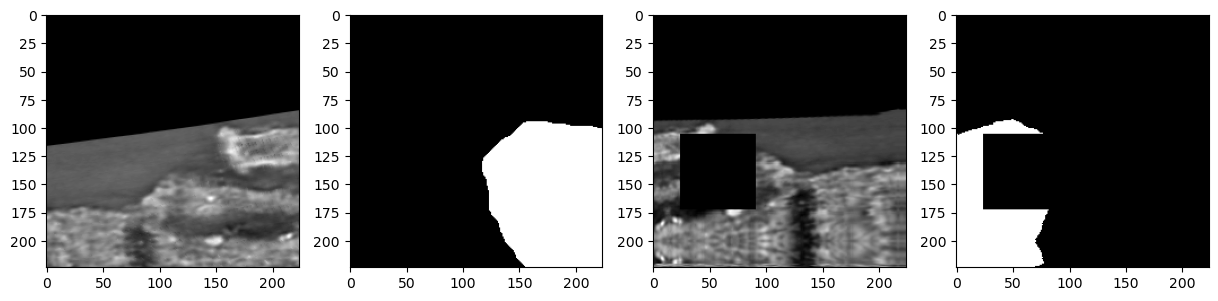

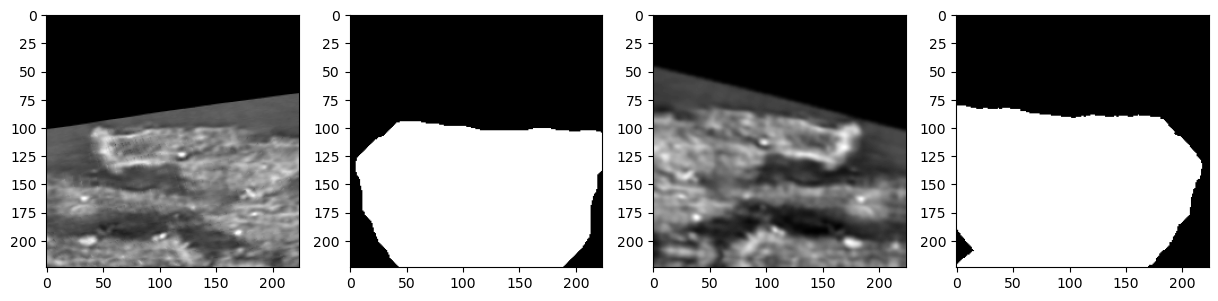

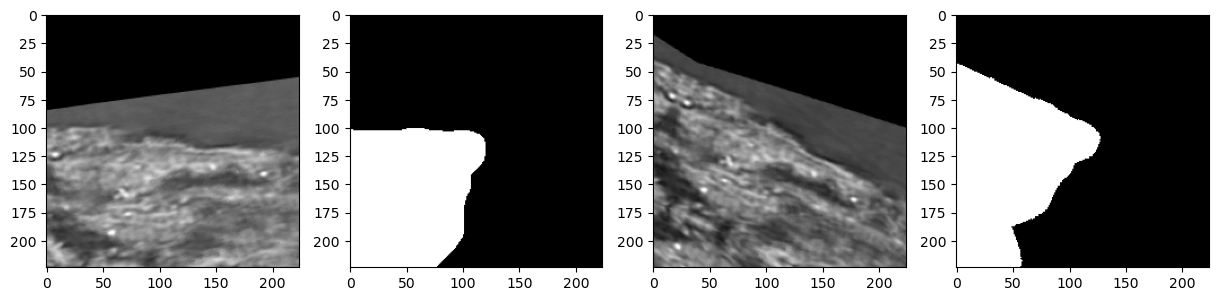

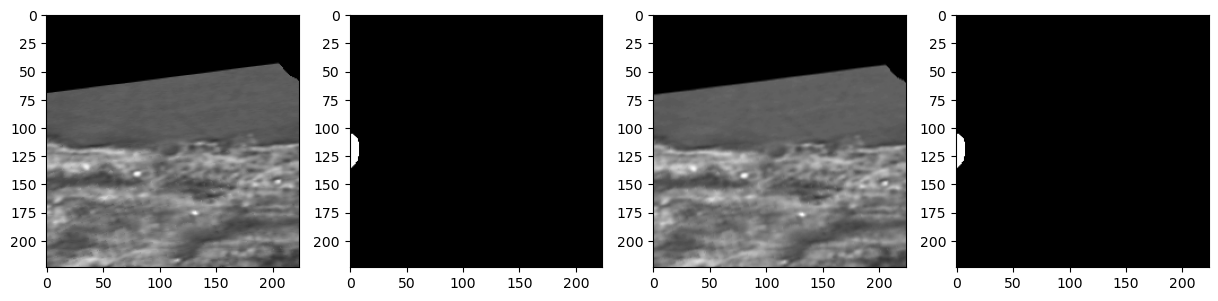

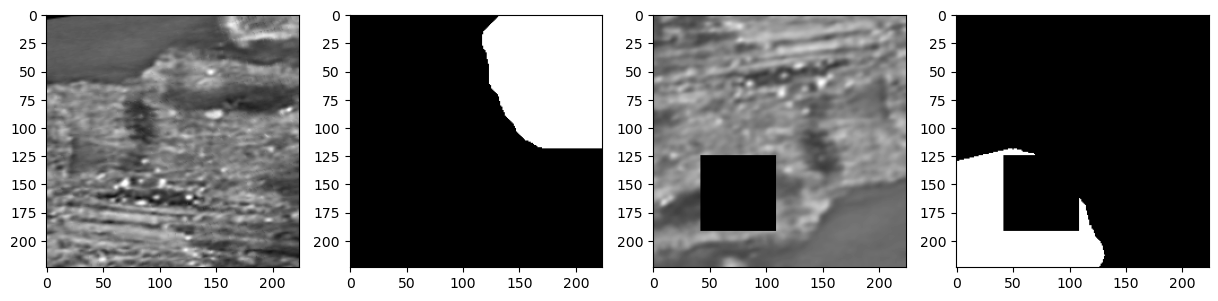

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48140

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09503029615037327
th: 0.15, fbeta: 0.14495886679076525
th: 0.2, fbeta: 0.20134975178612943
th: 0.25, fbeta: 0.31715754988527123
th: 0.3, fbeta: 0.38345374482121
th: 0.35, fbeta: 0.41452152952334576
th: 0.4, fbeta: 0.42146951517654646
th: 0.45, fbeta: 0.3866305708925394


best_th: 0.4, fbeta: 0.42146951517654646
Epoch 1 - avg_train_loss: 0.4663  avg_val_loss: 0.3003  time: 211s
Epoch 1 - avgScore: 0.4215
Epoch 1 - Save Best Score: 0.4215 Model
Epoch 1 - Save Best Loss: 0.3003 Model


th: 0.5, fbeta: 0.25455464004518724


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.15259815101732532
th: 0.15, fbeta: 0.21919779295167274
th: 0.2, fbeta: 0.3370419943502191
th: 0.25, fbeta: 0.40911772158833637
th: 0.3, fbeta: 0.4460656136449511
th: 0.35, fbeta: 0.46804917498443815
th: 0.4, fbeta: 0.47916926673714005


best_th: 0.4, fbeta: 0.47916926673714005
Epoch 2 - avg_train_loss: 0.3223  avg_val_loss: 0.2423  time: 216s
Epoch 2 - avgScore: 0.4792
Epoch 2 - Save Best Score: 0.4792 Model
Epoch 2 - Save Best Loss: 0.2423 Model


th: 0.45, fbeta: 0.4768344635920572
th: 0.5, fbeta: 0.43661140205367394


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.31255426290656096
th: 0.15, fbeta: 0.36406639123210083
th: 0.2, fbeta: 0.39019311494266
th: 0.25, fbeta: 0.4146735552469188
th: 0.3, fbeta: 0.43495302127349383
th: 0.35, fbeta: 0.4448003387241385
th: 0.4, fbeta: 0.45287221740142924


best_th: 0.4, fbeta: 0.45287221740142924
Epoch 3 - avg_train_loss: 0.2793  avg_val_loss: 0.2038  time: 216s
Epoch 3 - avgScore: 0.4529


th: 0.45, fbeta: 0.4461821876918807
th: 0.5, fbeta: 0.4188146640498791


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2805712751933129
th: 0.15, fbeta: 0.322298525331602
th: 0.2, fbeta: 0.35825681049490216
th: 0.25, fbeta: 0.39060630555700876
th: 0.3, fbeta: 0.4188605583181033
th: 0.35, fbeta: 0.44399388912711724
th: 0.4, fbeta: 0.4704370424387147
th: 0.45, fbeta: 0.5004072050896469


best_th: 0.5, fbeta: 0.5283948886309509
Epoch 4 - avg_train_loss: 0.2573  avg_val_loss: 0.1976  time: 215s
Epoch 4 - avgScore: 0.5284
Epoch 4 - Save Best Score: 0.5284 Model
Epoch 4 - Save Best Loss: 0.1976 Model


th: 0.5, fbeta: 0.5283948886309509


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3700895526337782
th: 0.15, fbeta: 0.43543011942949994
th: 0.2, fbeta: 0.47645518096452244
th: 0.25, fbeta: 0.5050887602804791
th: 0.3, fbeta: 0.5235144475826943
th: 0.35, fbeta: 0.5365133400822039
th: 0.4, fbeta: 0.5440763149849985
th: 0.45, fbeta: 0.5469305332047988


best_th: 0.5, fbeta: 0.5485873070134839
Epoch 5 - avg_train_loss: 0.2468  avg_val_loss: 0.1869  time: 216s
Epoch 5 - avgScore: 0.5486
Epoch 5 - Save Best Score: 0.5486 Model
Epoch 5 - Save Best Loss: 0.1869 Model


th: 0.5, fbeta: 0.5485873070134839


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22165321936018362
th: 0.15, fbeta: 0.2655806712195911
th: 0.2, fbeta: 0.3171813046449793
th: 0.25, fbeta: 0.3719481898575919
th: 0.3, fbeta: 0.41949027810871287
th: 0.35, fbeta: 0.4589684431020962
th: 0.4, fbeta: 0.49877323250617717
th: 0.45, fbeta: 0.53183000340296


best_th: 0.5, fbeta: 0.5578028292511493
Epoch 6 - avg_train_loss: 0.2366  avg_val_loss: 0.2018  time: 214s
Epoch 6 - avgScore: 0.5578
Epoch 6 - Save Best Score: 0.5578 Model
Epoch 6 - Save Best Loss: 0.2018 Model


th: 0.5, fbeta: 0.5578028292511493


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2686348501381607
th: 0.15, fbeta: 0.3182880405937456
th: 0.2, fbeta: 0.3566895857871326
th: 0.25, fbeta: 0.38764411413572264
th: 0.3, fbeta: 0.4174844229460968
th: 0.35, fbeta: 0.44586036324863926
th: 0.4, fbeta: 0.47486266499797897


best_th: 0.5, fbeta: 0.5163236439538277
Epoch 7 - avg_train_loss: 0.2281  avg_val_loss: 0.2050  time: 218s
Epoch 7 - avgScore: 0.5163


th: 0.45, fbeta: 0.4978511864668683
th: 0.5, fbeta: 0.5163236439538277


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21973083249434835
th: 0.15, fbeta: 0.24966157027509092
th: 0.2, fbeta: 0.28775660628067073
th: 0.25, fbeta: 0.33690244030985655
th: 0.3, fbeta: 0.39978427154049123
th: 0.35, fbeta: 0.44560001055836856
th: 0.4, fbeta: 0.47965605427284486
th: 0.45, fbeta: 0.5098813397997993


best_th: 0.5, fbeta: 0.5311499462640049
Epoch 8 - avg_train_loss: 0.2198  avg_val_loss: 0.2081  time: 216s
Epoch 8 - avgScore: 0.5311


th: 0.5, fbeta: 0.5311499462640049


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3261068811660666
th: 0.15, fbeta: 0.37915143506688637
th: 0.2, fbeta: 0.4162155769953743
th: 0.25, fbeta: 0.4473279033262499
th: 0.3, fbeta: 0.4715461193108937
th: 0.35, fbeta: 0.48977290468752316
th: 0.4, fbeta: 0.5095749109330766
th: 0.45, fbeta: 0.5246289690564417


best_th: 0.5, fbeta: 0.5379330469281255
Epoch 9 - avg_train_loss: 0.2135  avg_val_loss: 0.2032  time: 217s
Epoch 9 - avgScore: 0.5379


th: 0.5, fbeta: 0.5379330469281255


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41028197127274596
th: 0.15, fbeta: 0.4665764417462128
th: 0.2, fbeta: 0.5035036771001107
th: 0.25, fbeta: 0.5319776111905421
th: 0.3, fbeta: 0.5467950707647389
th: 0.35, fbeta: 0.5500902617141128
th: 0.4, fbeta: 0.5477337571189719
th: 0.45, fbeta: 0.5432604688146516


best_th: 0.35, fbeta: 0.5500902617141128
Epoch 10 - avg_train_loss: 0.2053  avg_val_loss: 0.1937  time: 214s
Epoch 10 - avgScore: 0.5501


th: 0.5, fbeta: 0.5360385116400493


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4355990441673
th: 0.15, fbeta: 0.49459527923605107
th: 0.2, fbeta: 0.5267985471481682
th: 0.25, fbeta: 0.5413048959161656
th: 0.3, fbeta: 0.5482591156314143
th: 0.35, fbeta: 0.5462488955461826
th: 0.4, fbeta: 0.5411173862814347
th: 0.45, fbeta: 0.5263927695343089


best_th: 0.3, fbeta: 0.5482591156314143
Epoch 11 - avg_train_loss: 0.1967  avg_val_loss: 0.2043  time: 214s
Epoch 11 - avgScore: 0.5483


th: 0.5, fbeta: 0.49936899503256676


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3114158806753597
th: 0.15, fbeta: 0.3638513395033145
th: 0.2, fbeta: 0.40980505354278207
th: 0.25, fbeta: 0.4491579566417813
th: 0.3, fbeta: 0.4853277756574359
th: 0.35, fbeta: 0.5136457046339193
th: 0.4, fbeta: 0.5384944257624377
th: 0.45, fbeta: 0.5555602747779862


best_th: 0.5, fbeta: 0.5655613539017303
Epoch 12 - avg_train_loss: 0.1915  avg_val_loss: 0.1890  time: 215s
Epoch 12 - avgScore: 0.5656
Epoch 12 - Save Best Score: 0.5656 Model
Epoch 12 - Save Best Loss: 0.1890 Model


th: 0.5, fbeta: 0.5655613539017303


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40483090244656544
th: 0.15, fbeta: 0.4790574549413941
th: 0.2, fbeta: 0.5305126262249997
th: 0.25, fbeta: 0.5681893888216563
th: 0.3, fbeta: 0.5928632114385449
th: 0.35, fbeta: 0.6043452869785432
th: 0.4, fbeta: 0.6109893151794157
th: 0.45, fbeta: 0.607599566674896


best_th: 0.4, fbeta: 0.6109893151794157
Epoch 13 - avg_train_loss: 0.1875  avg_val_loss: 0.1887  time: 216s
Epoch 13 - avgScore: 0.6110
Epoch 13 - Save Best Score: 0.6110 Model
Epoch 13 - Save Best Loss: 0.1887 Model


th: 0.5, fbeta: 0.590392584538771


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2854556819655751
th: 0.15, fbeta: 0.3227804095304342
th: 0.2, fbeta: 0.356053729037218
th: 0.25, fbeta: 0.38804333825806103
th: 0.3, fbeta: 0.41803469293623746
th: 0.35, fbeta: 0.4450949070251677
th: 0.4, fbeta: 0.4694245513811188
th: 0.45, fbeta: 0.4933150198644749


best_th: 0.5, fbeta: 0.514409839629157
Epoch 14 - avg_train_loss: 0.1758  avg_val_loss: 0.2106  time: 216s
Epoch 14 - avgScore: 0.5144


th: 0.5, fbeta: 0.514409839629157


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3745153369518366
th: 0.15, fbeta: 0.4087275778640227
th: 0.2, fbeta: 0.4375908957831128
th: 0.25, fbeta: 0.46584069755773494
th: 0.3, fbeta: 0.49028085359463053
th: 0.35, fbeta: 0.5098405572050159
th: 0.4, fbeta: 0.5279819545086768
th: 0.45, fbeta: 0.543713328965752


best_th: 0.5, fbeta: 0.5570744155050746
Epoch 15 - avg_train_loss: 0.1657  avg_val_loss: 0.2016  time: 216s
Epoch 15 - avgScore: 0.5571


th: 0.5, fbeta: 0.5570744155050746


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.321279136302853
th: 0.15, fbeta: 0.3703175643923209
th: 0.2, fbeta: 0.4081140059361638
th: 0.25, fbeta: 0.44245728215490626
th: 0.3, fbeta: 0.4731077173083149
th: 0.35, fbeta: 0.49964854214571625
th: 0.4, fbeta: 0.520573195630943
th: 0.45, fbeta: 0.5388822024354185


best_th: 0.5, fbeta: 0.5545044981745345
Epoch 16 - avg_train_loss: 0.1678  avg_val_loss: 0.1988  time: 215s
Epoch 16 - avgScore: 0.5545


th: 0.5, fbeta: 0.5545044981745345


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3477217535503554
th: 0.15, fbeta: 0.3989167342104345
th: 0.2, fbeta: 0.43696485242307304
th: 0.25, fbeta: 0.4679443639435379
th: 0.3, fbeta: 0.49145908098763186
th: 0.35, fbeta: 0.511675860252942
th: 0.4, fbeta: 0.5245614156825549
th: 0.45, fbeta: 0.5333605722824378


best_th: 0.5, fbeta: 0.5414609066511109
Epoch 17 - avg_train_loss: 0.1540  avg_val_loss: 0.2134  time: 215s
Epoch 17 - avgScore: 0.5415


th: 0.5, fbeta: 0.5414609066511109


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32799925430659743
th: 0.15, fbeta: 0.37041654130129
th: 0.2, fbeta: 0.4047124324040307
th: 0.25, fbeta: 0.43370511213336427
th: 0.3, fbeta: 0.46354782632308306
th: 0.35, fbeta: 0.48955891334041785
th: 0.4, fbeta: 0.5114194095815536
th: 0.45, fbeta: 0.5301935004473024


best_th: 0.5, fbeta: 0.5446469665222858
Epoch 18 - avg_train_loss: 0.1455  avg_val_loss: 0.2101  time: 216s
Epoch 18 - avgScore: 0.5446


th: 0.5, fbeta: 0.5446469665222858


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.357241379462831
th: 0.15, fbeta: 0.4079864839697441
th: 0.2, fbeta: 0.4501495060730132
th: 0.25, fbeta: 0.4872491674699467
th: 0.3, fbeta: 0.5181174637575188
th: 0.35, fbeta: 0.5415116857702406
th: 0.4, fbeta: 0.5595895863638889
th: 0.45, fbeta: 0.5712205247164818


best_th: 0.5, fbeta: 0.5756386606132942
Epoch 19 - avg_train_loss: 0.1387  avg_val_loss: 0.2107  time: 217s
Epoch 19 - avgScore: 0.5756


th: 0.5, fbeta: 0.5756386606132942


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29990068983204854
th: 0.15, fbeta: 0.3287309366002261
th: 0.2, fbeta: 0.35540031845298065
th: 0.25, fbeta: 0.38159334650230126
th: 0.3, fbeta: 0.4071654205299821
th: 0.35, fbeta: 0.4331571807054896
th: 0.4, fbeta: 0.4596432664044955
th: 0.45, fbeta: 0.4815732595948312


best_th: 0.5, fbeta: 0.5015702641630326
Epoch 20 - avg_train_loss: 0.1367  avg_val_loss: 0.2404  time: 215s
Epoch 20 - avgScore: 0.5016


th: 0.5, fbeta: 0.5015702641630326


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41737083782607254
th: 0.15, fbeta: 0.4661009553592423
th: 0.2, fbeta: 0.4983720744575434
th: 0.25, fbeta: 0.5223210896977942
th: 0.3, fbeta: 0.5442983258772314
th: 0.35, fbeta: 0.5588285230025033
th: 0.4, fbeta: 0.5697236835438678
th: 0.45, fbeta: 0.5773626031724739


best_th: 0.5, fbeta: 0.5804974230495142
Epoch 21 - avg_train_loss: 0.1274  avg_val_loss: 0.2301  time: 215s
Epoch 21 - avgScore: 0.5805


th: 0.5, fbeta: 0.5804974230495142


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4014159929923451
th: 0.15, fbeta: 0.4449045245315381
th: 0.2, fbeta: 0.4800423178532363
th: 0.25, fbeta: 0.5119085372674125
th: 0.3, fbeta: 0.5353622824477187
th: 0.35, fbeta: 0.5552337856058102
th: 0.4, fbeta: 0.5719359287897269
th: 0.45, fbeta: 0.5830014945586831


best_th: 0.5, fbeta: 0.5873791678967608
Epoch 22 - avg_train_loss: 0.1228  avg_val_loss: 0.2175  time: 219s
Epoch 22 - avgScore: 0.5874


th: 0.5, fbeta: 0.5873791678967608


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37523922253136116
th: 0.15, fbeta: 0.41601538011757905
th: 0.2, fbeta: 0.4515062082844678
th: 0.25, fbeta: 0.4811934560015164
th: 0.3, fbeta: 0.5041699376675945
th: 0.35, fbeta: 0.5236864892288133
th: 0.4, fbeta: 0.5390048304665321
th: 0.45, fbeta: 0.5528513733014669


best_th: 0.5, fbeta: 0.5609830229324987
Epoch 23 - avg_train_loss: 0.1189  avg_val_loss: 0.2296  time: 215s
Epoch 23 - avgScore: 0.5610


th: 0.5, fbeta: 0.5609830229324987


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3337399146694552
th: 0.15, fbeta: 0.36605856188861824
th: 0.2, fbeta: 0.39497361596592845
th: 0.25, fbeta: 0.42312425133884973
th: 0.3, fbeta: 0.44803031899934237
th: 0.35, fbeta: 0.46989689237856064
th: 0.4, fbeta: 0.48786447917603765
th: 0.45, fbeta: 0.5042505232400349


best_th: 0.5, fbeta: 0.5219552552352961
Epoch 24 - avg_train_loss: 0.1151  avg_val_loss: 0.2403  time: 217s
Epoch 24 - avgScore: 0.5220


th: 0.5, fbeta: 0.5219552552352961


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30465279213221186
th: 0.15, fbeta: 0.3337668576191079
th: 0.2, fbeta: 0.3593004931065569
th: 0.25, fbeta: 0.38385113318519376
th: 0.3, fbeta: 0.40523895153954126
th: 0.35, fbeta: 0.42738451496072644
th: 0.4, fbeta: 0.4482317244431116
th: 0.45, fbeta: 0.46700093007222254


best_th: 0.5, fbeta: 0.4872309648475082
Epoch 25 - avg_train_loss: 0.1127  avg_val_loss: 0.2545  time: 213s
Epoch 25 - avgScore: 0.4872


th: 0.5, fbeta: 0.4872309648475082


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29170197714631646
th: 0.15, fbeta: 0.3175190225910957
th: 0.2, fbeta: 0.34128005919184357
th: 0.25, fbeta: 0.3654414848868168
th: 0.3, fbeta: 0.3878206074843433
th: 0.35, fbeta: 0.41088432589818846
th: 0.4, fbeta: 0.4338112911339584
th: 0.45, fbeta: 0.45533996312730185


best_th: 0.5, fbeta: 0.4748986703010447
Epoch 26 - avg_train_loss: 0.1093  avg_val_loss: 0.2610  time: 215s
Epoch 26 - avgScore: 0.4749


th: 0.5, fbeta: 0.4748986703010447


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32690654290165916
th: 0.15, fbeta: 0.3582960085171098
th: 0.2, fbeta: 0.38485702056075494
th: 0.25, fbeta: 0.4077368796998209
th: 0.3, fbeta: 0.42997944000241595
th: 0.35, fbeta: 0.45345391138160523
th: 0.4, fbeta: 0.4739165497058849
th: 0.45, fbeta: 0.493400370053673


best_th: 0.5, fbeta: 0.5119414901088263
Epoch 27 - avg_train_loss: 0.1035  avg_val_loss: 0.2579  time: 217s
Epoch 27 - avgScore: 0.5119


th: 0.5, fbeta: 0.5119414901088263


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33410207855281526
th: 0.15, fbeta: 0.3643404176368141
th: 0.2, fbeta: 0.3939371929019826
th: 0.25, fbeta: 0.41943825515164
th: 0.3, fbeta: 0.44156438988548113
th: 0.35, fbeta: 0.4632160186152969
th: 0.4, fbeta: 0.4827267062938273
th: 0.45, fbeta: 0.5009743995119035


best_th: 0.5, fbeta: 0.5163508511465977
Epoch 28 - avg_train_loss: 0.1027  avg_val_loss: 0.2609  time: 216s
Epoch 28 - avgScore: 0.5164


th: 0.5, fbeta: 0.5163508511465977


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31172289821576954
th: 0.15, fbeta: 0.3388739807612683
th: 0.2, fbeta: 0.3642694585992546
th: 0.25, fbeta: 0.38877671221931187
th: 0.3, fbeta: 0.41194443790166513
th: 0.35, fbeta: 0.43287254889182114
th: 0.4, fbeta: 0.45410385526012825
th: 0.45, fbeta: 0.4739952826990236


best_th: 0.5, fbeta: 0.4921037400521409
Epoch 29 - avg_train_loss: 0.1003  avg_val_loss: 0.2661  time: 218s
Epoch 29 - avgScore: 0.4921


th: 0.5, fbeta: 0.4921037400521409


  0%|          | 0/1933 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3399658074992929
th: 0.15, fbeta: 0.3704041552832768
th: 0.2, fbeta: 0.39946445275017317
th: 0.25, fbeta: 0.42582501381717447
th: 0.3, fbeta: 0.44728504759577964
th: 0.35, fbeta: 0.4663560196239725
th: 0.4, fbeta: 0.48476640310125874
th: 0.45, fbeta: 0.5016516937124444


best_th: 0.5, fbeta: 0.5134072352942975
Epoch 30 - avg_train_loss: 0.1003  avg_val_loss: 0.2666  time: 214s
Epoch 30 - avgScore: 0.5134


th: 0.5, fbeta: 0.5134072352942975


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.40483090244656544
th: 0.15, fbeta: 0.4790574549413941
th: 0.2, fbeta: 0.5305126262249997
th: 0.25, fbeta: 0.5681893888216563
th: 0.3, fbeta: 0.5928632114385449
th: 0.35, fbeta: 0.6043452869785432
th: 0.4, fbeta: 0.6109893151794157
th: 0.45, fbeta: 0.607599566674896


best_th: 0.4, fbeta: 0.6109893151794157


th: 0.5, fbeta: 0.590392584538771


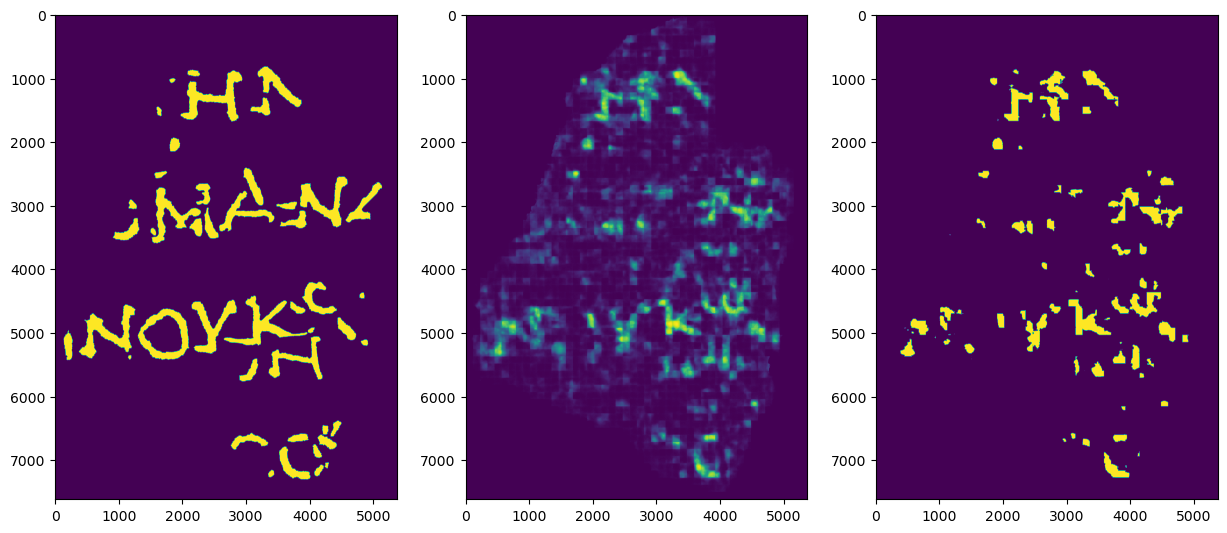

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([3.0987016e+07, 3.5891220e+06, 1.7479090e+06, 9.8613200e+05,
        7.0768000e+05, 4.9670900e+05, 3.8346400e+05, 3.0709400e+05,
        2.7478900e+05, 2.4569000e+05, 1.9845200e+05, 1.8080100e+05,
        1.5436100e+05, 1.6527200e+05, 1.7023100e+05, 1.4664500e+05,
        1.0899600e+05, 5.7799000e+04, 2.3842000e+04, 1.1612000e+04]),
 array([3.04927715e-11, 4.83541496e-02, 9.67082992e-02, 1.45062449e-01,
        1.93416598e-01, 2.41770748e-01, 2.90124898e-01, 3.38479047e-01,
        3.86833197e-01, 4.35187347e-01, 4.83541496e-01, 5.31895646e-01,
        5.80249795e-01, 6.28603945e-01, 6.76958095e-01, 7.25312244e-01,
        7.73666394e-01, 8.22020543e-01, 8.70374693e-01, 9.18728843e-01,
        9.67082992e-01]),
 <BarContainer object of 20 artists>)

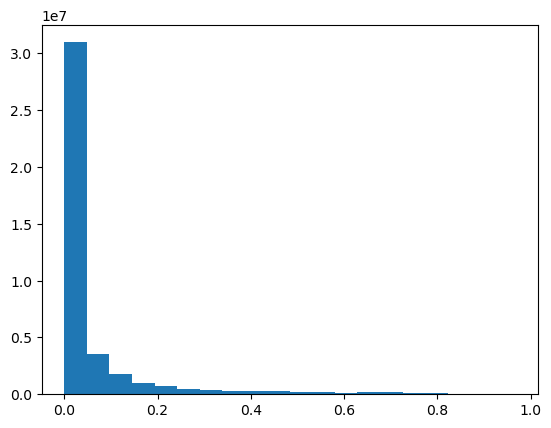

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000